# Weather-guided Earth Surface Forecasting with Earthformer on EarthNet2021x

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/amazon-science/earth-forecasting-transformer/blob/main/scripts/cuboid_transformer/earthnet_w_meso/inference_tutorial_earthformer_earthnet2021.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amazon-science/earth-forecasting-transformer/blob/main/scripts/cuboid_transformer/earthnet_w_meso/inference_tutorial_earthformer_earthnet2021.ipynb)

In this tutorial, we will demonstrate how to apply [Earthformer](https://assets.amazon.science/89/ad/cb9c23dd4bb69b8e03bbbecdb4b8/earthformer-exploring-space-time-transformers-for-earth-system-forecasting.pdf) for *weather-guided* Earth surface forecasting. The goal of the task is to predict the future land surface based on both the previous land surface observations and the future weather. This is an important problem because the future Earth surface can reflect the potential agricultural output and the ecosystem health. We will use the [EarthNet2021](https://arxiv.org/pdf/2104.10066.pdf) dataset. EarthNet2021 contains Sentinel-2 imagery at the 20 m resolution as well as the topography and mesoscale (1.28 km) meteorological variables collected from [E-OBS](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2017JD028200). We will show how Earthformer can help predict the land surface in the future 100 days (5-daily prediction) based on the observational data from the previous 50 days and the weather forecasts.

*Note*: For running this tutorial, you need to use a GPU instance. If you are using SageMaker Studio Lab or Google Colab, simply pick runtime to be `GPU`.

## Load and Visualize EarthNet2021x

For the purpose of demonstration, we download a small subset of the IID-test split of EarthNet2021.

In [1]:
from omegaconf import OmegaConf
from earthformer.datasets.earthnet.earthnet21x_dataloader import EarthNet2021xLightningDataModule, EarthNet2021xTestDataset
from pytorch_lightning import Trainer, seed_everything, loggers as pl_loggers
from earthformer.datasets.earthnet.visualization import vis_earthnet_seq
import numpy as np
from pathlib import Path

config_file = "./earthformer_earthnet_v1.yaml"
config = OmegaConf.load(open(config_file, "r"))
in_len = config.layout.in_len
out_len = config.layout.out_len

seed = config.optim.seed
dataset_cfg = OmegaConf.to_object(config.dataset)

seed_everything(seed, workers=True)

micro_batch_size = 1

earthnet_iid_testset = EarthNet2021xTestDataset(subset_name="iid",
                                               data_dir="/Net/Groups/BGI/work_1/scratch/s3/earthnet/earthnet2021x/iid/",
                                               layout=config.dataset.layout,
                                               static_layout=config.dataset.static_layout,
                                               highresstatic_expand_t=config.dataset.highresstatic_expand_t,
                                               mesostatic_expand_t=config.dataset.mesostatic_expand_t,
                                               meso_crop=None,
                                               fp16=False)
total_num_test_samples = len(earthnet_iid_testset)
print("The total number samples in the IID test subset is", total_num_test_samples)

/Net/Groups/BGI/people/vbenson/miniconda3/envs/earthformer/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


The total number samples in the IID test subset is 4205


Each sample in the dataset contains four components:

- **"highresdynamic"**: The Sentinel-2 landcover data. The bands are "blue", "green", "red", "nir", "cloud". We will use the first four bands in this problem. This dataset will be 5-daily, meaning that there will be one observation in 5 days. The size of each frame is 128x128.

- **"highresstatic"**: The elevation of the Sentinel-2 data.

- **"mesodynamic"**: The mesoscale weather data. The bands are "precipitation", "pressure", "temp mean", "temp min", "temp max". The data will be daily and the size of each frame is 80x80.

- **"mesostatic"**: The elevation of the mesoscale weather data.

We will use the first 10 frames of **"highresdynamics"** and the auxiliary data (**highresstatic**, **mesodynamic**, **mesostatic**) to predict the future 20 frames of **"highresdynamics"**. This is equivalent to using the land surface data in the previous 50 days to predict the land surface data in the coming 100 days.

Let's first visualize some data samples:

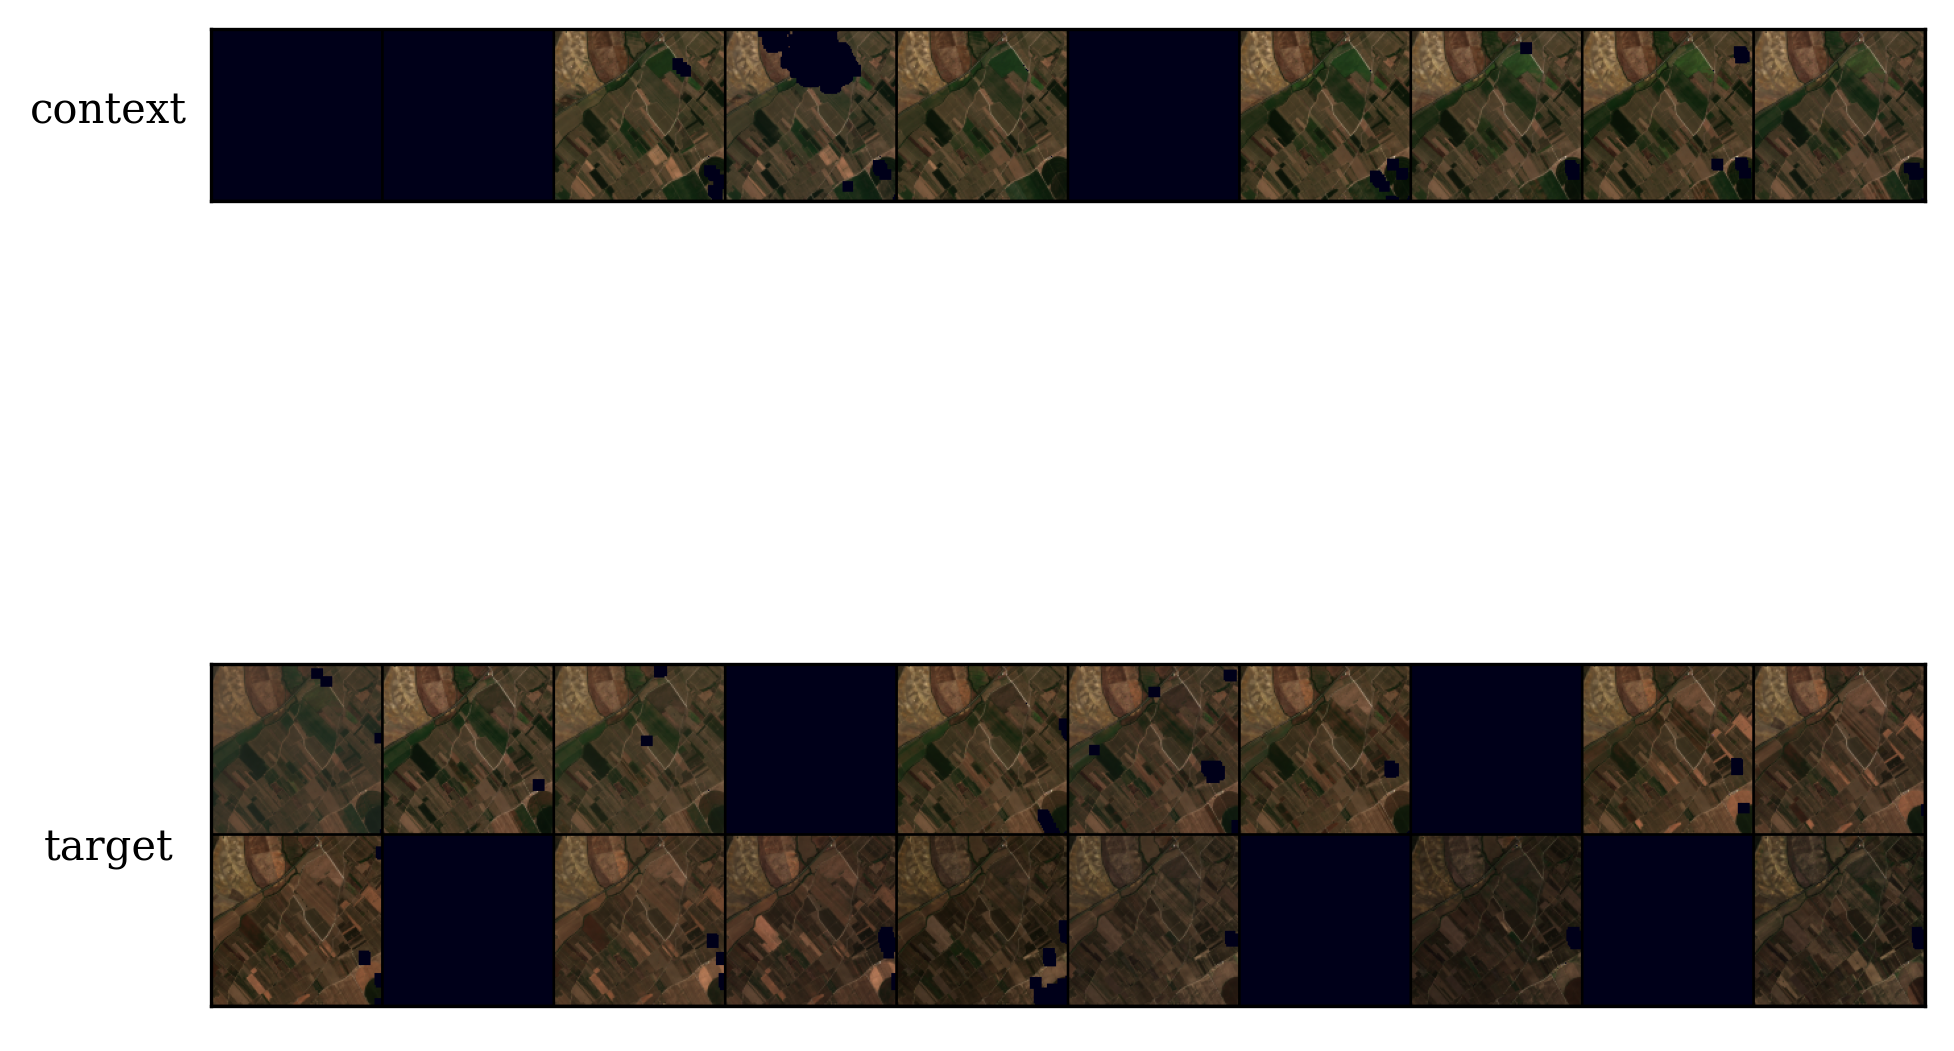

In [2]:
idx = 1

def process_sample(sample):
    # High-resolution Earth surface data. The channels are [blue, green, red, nir, cloud]
    highresdynamic = sample['highresdynamic']
    highresstatic = sample['highresstatic']

    # The meso-scale data. The channels are ["precipitation", "pressure", "temp mean", "temp min", "temp max"]
    mesodynamic = sample['mesodynamic']
    mesostatic = sample['mesostatic']

    highresdynamic = np.nan_to_num(highresdynamic, nan=0.0, posinf=1.0, neginf=0.0)
    highresdynamic = np.clip(highresdynamic, a_min=0.0, a_max=1.0)
    mesodynamic = np.nan_to_num(mesodynamic, nan=0.0)
    highresstatic = np.nan_to_num(highresstatic, nan=0.0)
    mesostatic = np.nan_to_num(mesostatic, nan=0.0)
    return highresdynamic, highresstatic, mesodynamic, mesostatic

highresdynamic, highresstatic, mesodynamic, mesostatic = process_sample(earthnet_iid_testset[idx])

highresdynamic_in, highresdynamic_out = highresdynamic[:in_len, ...], highresdynamic[in_len:, ...]
highresstatic_in, highresstatic_out = highresstatic[:in_len, ...], highresstatic[in_len:, ...]
mesodynamic_in, mesodynamic_out = mesodynamic[:in_len, ...], mesodynamic[in_len:, ...]
mesostatic_in, mesostatic_out = mesostatic[:in_len, ...], mesostatic[in_len:, ...]

fig_rgb = vis_earthnet_seq(context_np=np.expand_dims(highresdynamic_in, axis=0),
                       target_np=np.expand_dims(highresdynamic_out, axis=0),
                       pred_np=None,
                       layout='N' + config.dataset.layout)

You may notice that some frames are blank. This is because EarthNet2021 contains a "data quality mask" that indicates noise in the data. Earth observations are usually very noisy (due to factors like cloud or observational errors). We simply display the noisy pixels with the black value, and have masked them from the loss functions when training the neural network.

Following is the NDVI index calculated via the formula: $NDVI=\frac{I_{\text{NIR}} - I_{\text{red}}}{I_{\text{NIR}} + I_{\text{red}}}$. It quantifies vegetation by measuring the difference between near-infrared (which vegetation strongly reflects) and red light (which vegetation absorbs). See the following image from NASA for an illustration of NDVI:

![Image courtesy of NASA.](https://gisgeography.com/wp-content/uploads/2017/08/ndvi-example.jpg)

Thus, one important use-case of our model is that it can also predict the future NDVI. Here, let's visualize the NDVI values of the EarthNet2021 sample.

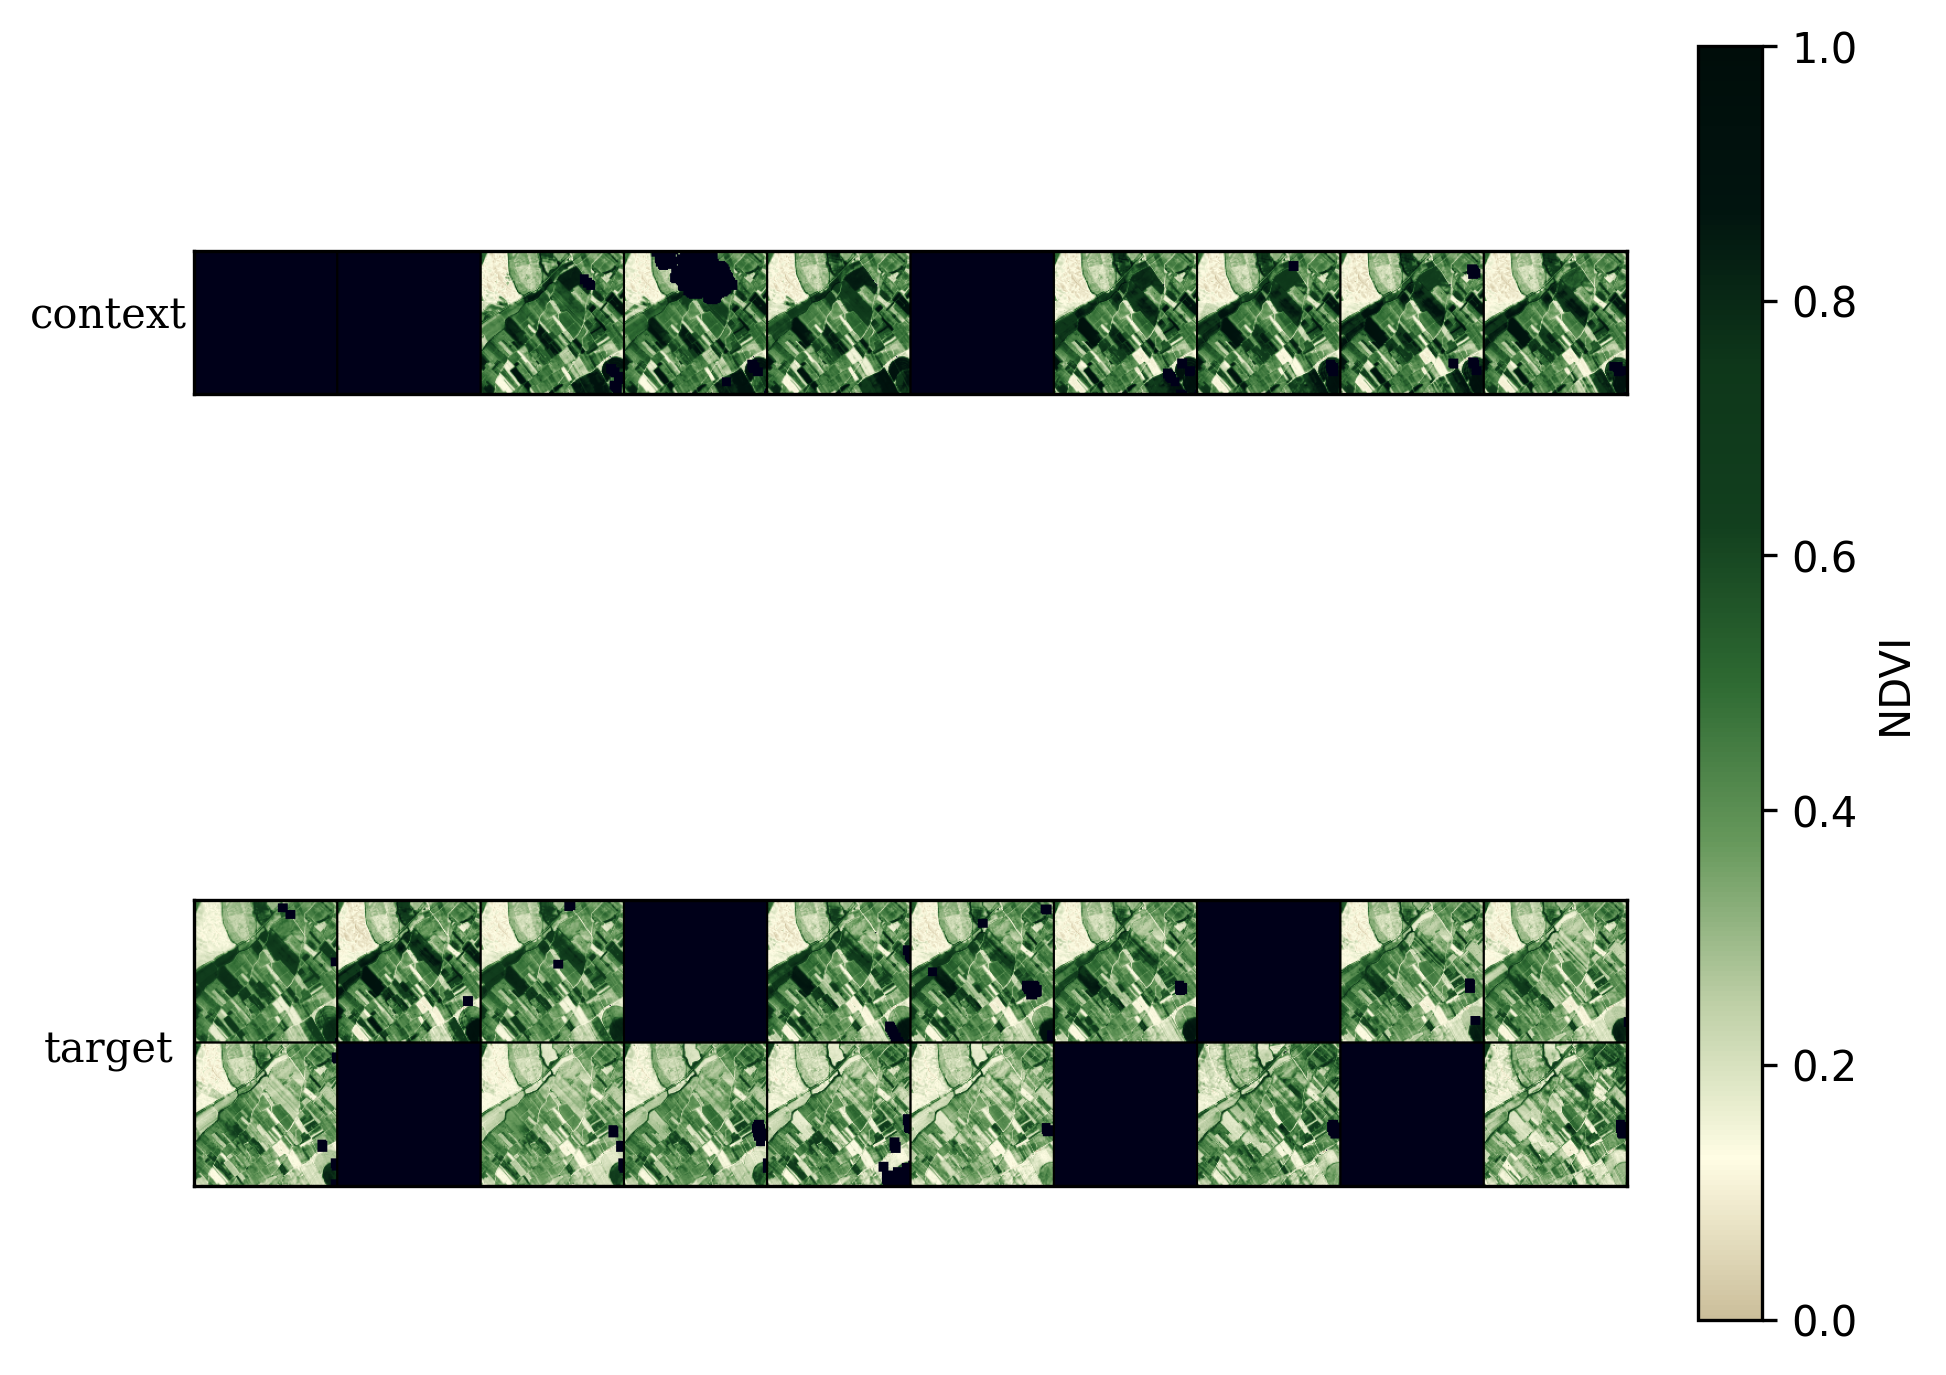

In [3]:
fig_ndvi = vis_earthnet_seq(context_np=np.expand_dims(highresdynamic_in, axis=0),
                            target_np=np.expand_dims(highresdynamic_out, axis=0),
                            pred_np=None,
                            layout='N' + config.dataset.layout,
                            variable="ndvi")

## Brief Introduction of Earthformer

Conventionally, Earth system (e.g., weather and climate) forecasting relies on numerical simulation with complex physical models and are hence both expensive in computation and demanding on domain expertise. With the explosive growth of the spatiotemporal Earth observation data in the past decade, data-driven models that apply Deep Learning (DL) are demonstrating impressive potential for various Earth system forecasting tasks. The Transformer as an emerging DL architecture, despite its broad success in other domains, has limited adoption in this area. In this paper, we propose Earthformer, a space-time Transformer for Earth system forecasting. Earthformer is based on a generic, flexible and efficient space-time attention block, named Cuboid Attention. The idea is to decompose the data into cuboids and apply cuboid-level self-attention in parallel. These cuboids are further connected with a collection of global vectors.

Earthformer achieves strong results in synthetic datasets like MovingMNIST and N-body MNIST dataset, and also outperforms non-Transformer models (like ConvLSTM, CNN-U-Net) in SEVIR (precipitation nowcasting) and ICAR-ENSO2021 (El Nino/Southern Oscillation forecasting).

<img src="https://raw.githubusercontent.com/amazon-science/earth-forecasting-transformer/main/figures/teaser.png" width="800"/>


For more details, you may check [our paper](https://assets.amazon.science/89/ad/cb9c23dd4bb69b8e03bbbecdb4b8/earthformer-exploring-space-time-transformers-for-earth-system-forecasting.pdf).

## Load Pretrained Earthformer

We load the Earthformer pretrained on the training set of EarthNet2021. The model is current **rank-1** in [EarthNet2021 leaderboard](https://www.earthnet.tech/docs/ch-leaderboard/).

In [4]:
import torch
import os
from train_cuboid_earthnet import CuboidEarthNet2021PLModule
from earthformer.utils.utils import download

save_dir = "./experiments"

pl_module = CuboidEarthNet2021PLModule(
    total_num_steps=None,
    save_dir="./experiments",
    oc_file=config_file
)

pretrained_checkpoint_url = "https://earthformer.s3.amazonaws.com/pretrained_checkpoints/earthformer_earthnet2021.pt"
local_checkpoint_path = os.path.join(save_dir, "earthformer_earthnet2021.pt")
download(url=pretrained_checkpoint_url, path=local_checkpoint_path)

state_dict = torch.load(local_checkpoint_path, map_location=torch.device("cpu"))
pl_module.torch_nn_module.load_state_dict(state_dict=state_dict)

/Net/Groups/BGI/people/vbenson/miniconda3/envs/earthformer/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [5]:
pl_module.torch_nn_module.cuda()
pl_module.torch_nn_module.eval()

with torch.no_grad():
    pred_seq, loss, in_seq, target_seq, mask = pl_module({"highresdynamic": torch.tensor(np.expand_dims(highresdynamic, axis=0)).cuda(), 
                                                          "highresstatic": torch.tensor(np.expand_dims(highresstatic, axis=0)).cuda(),
                                                          "mesodynamic": torch.tensor(np.expand_dims(mesodynamic, axis=0)).cuda(),
                                                          "mesostatic": torch.tensor(np.expand_dims(mesostatic, axis=0)).cuda()})
    pred_seq_np = pred_seq.detach().cpu().numpy()

    print("loss=", loss.detach().cpu().numpy())

loss= 0.0007613373


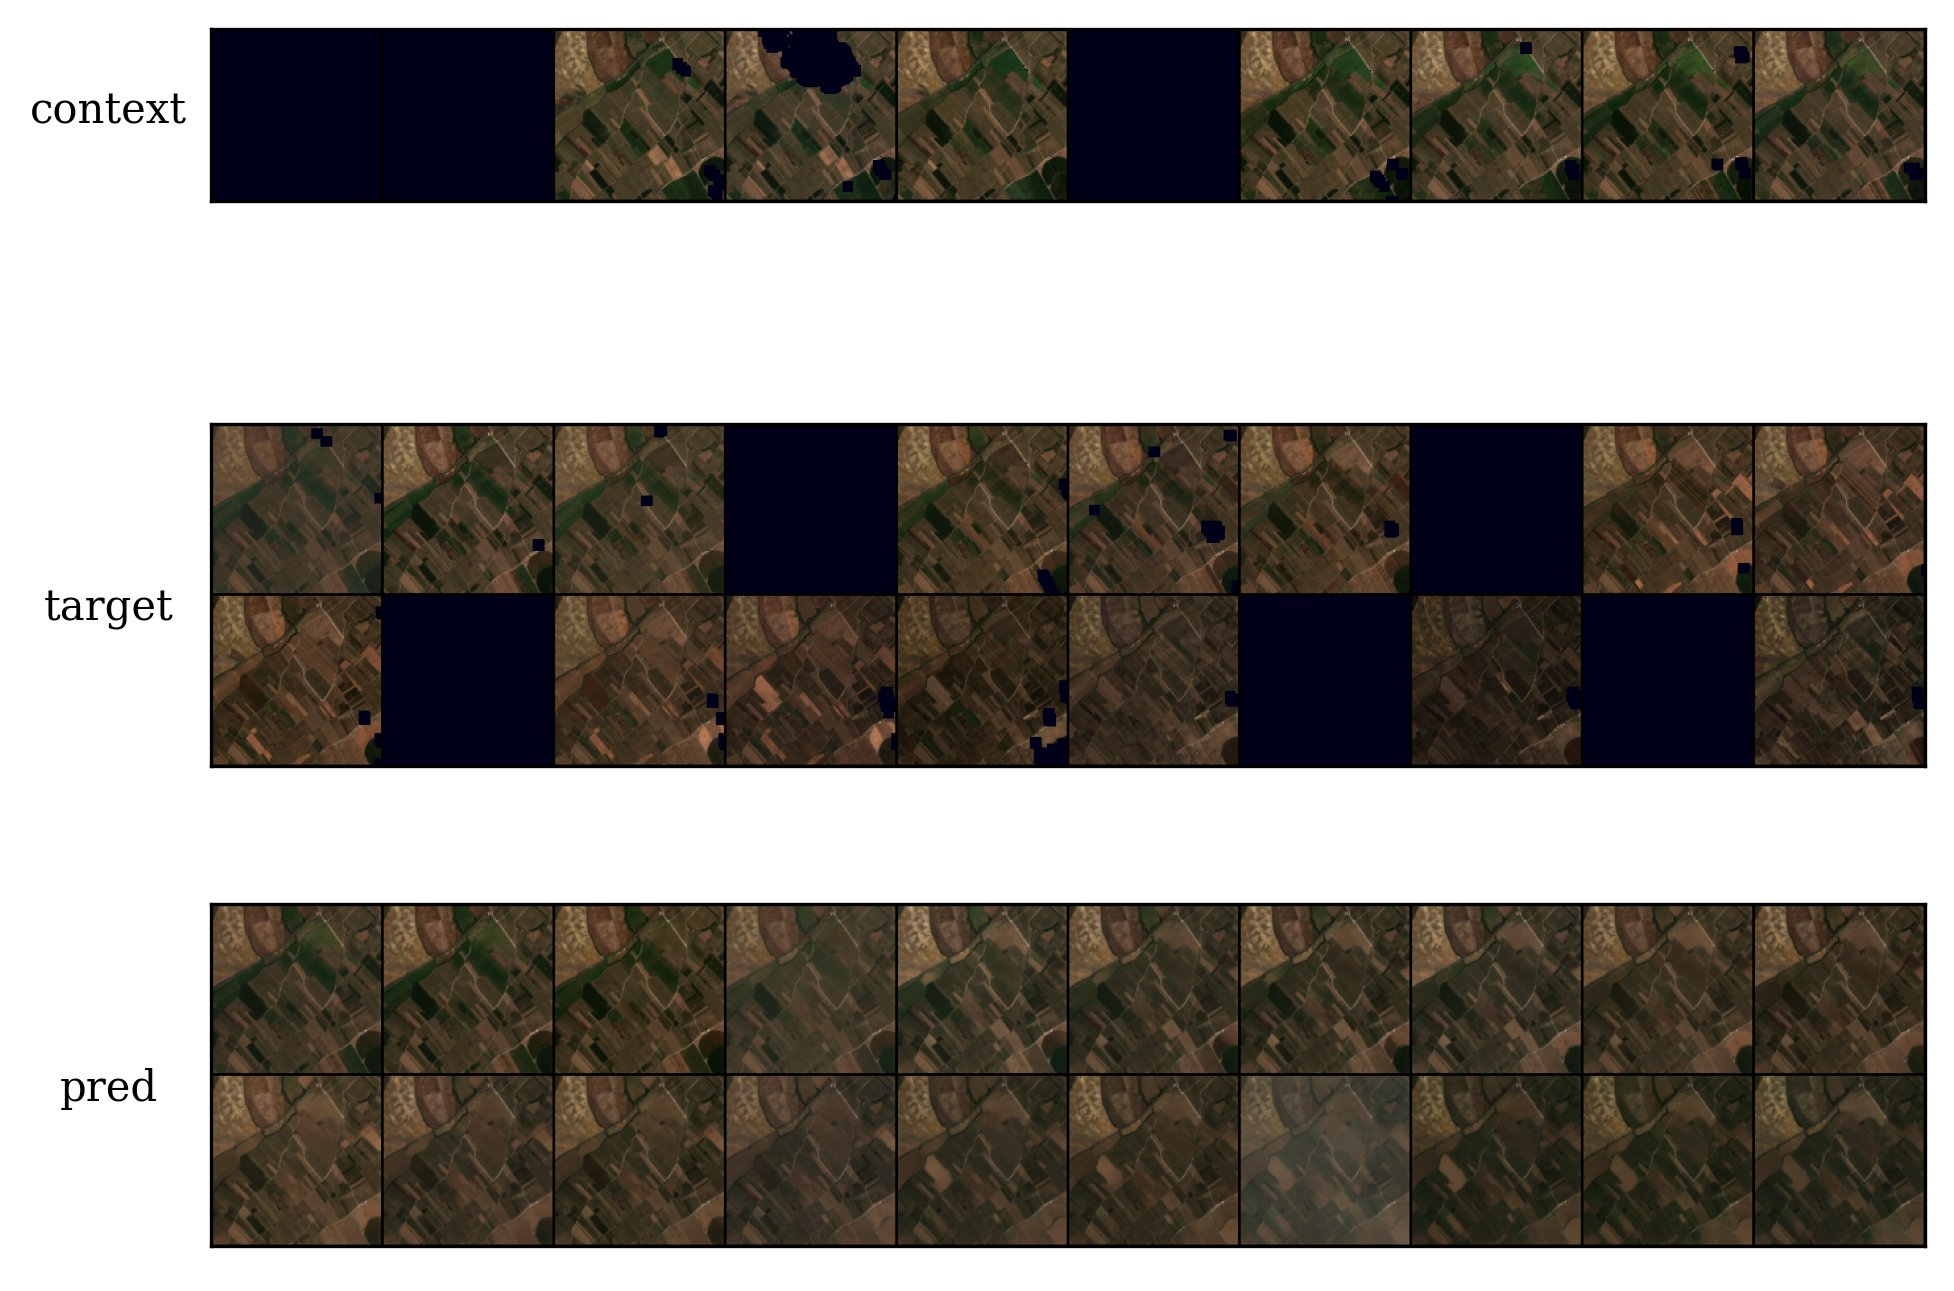

In [6]:
fig_rgb = vis_earthnet_seq(context_np=np.expand_dims(highresdynamic_in, axis=0),
                           target_np=np.expand_dims(highresdynamic_out, axis=0),
                           pred_np=pred_seq_np,
                           layout='N' + config.dataset.layout)

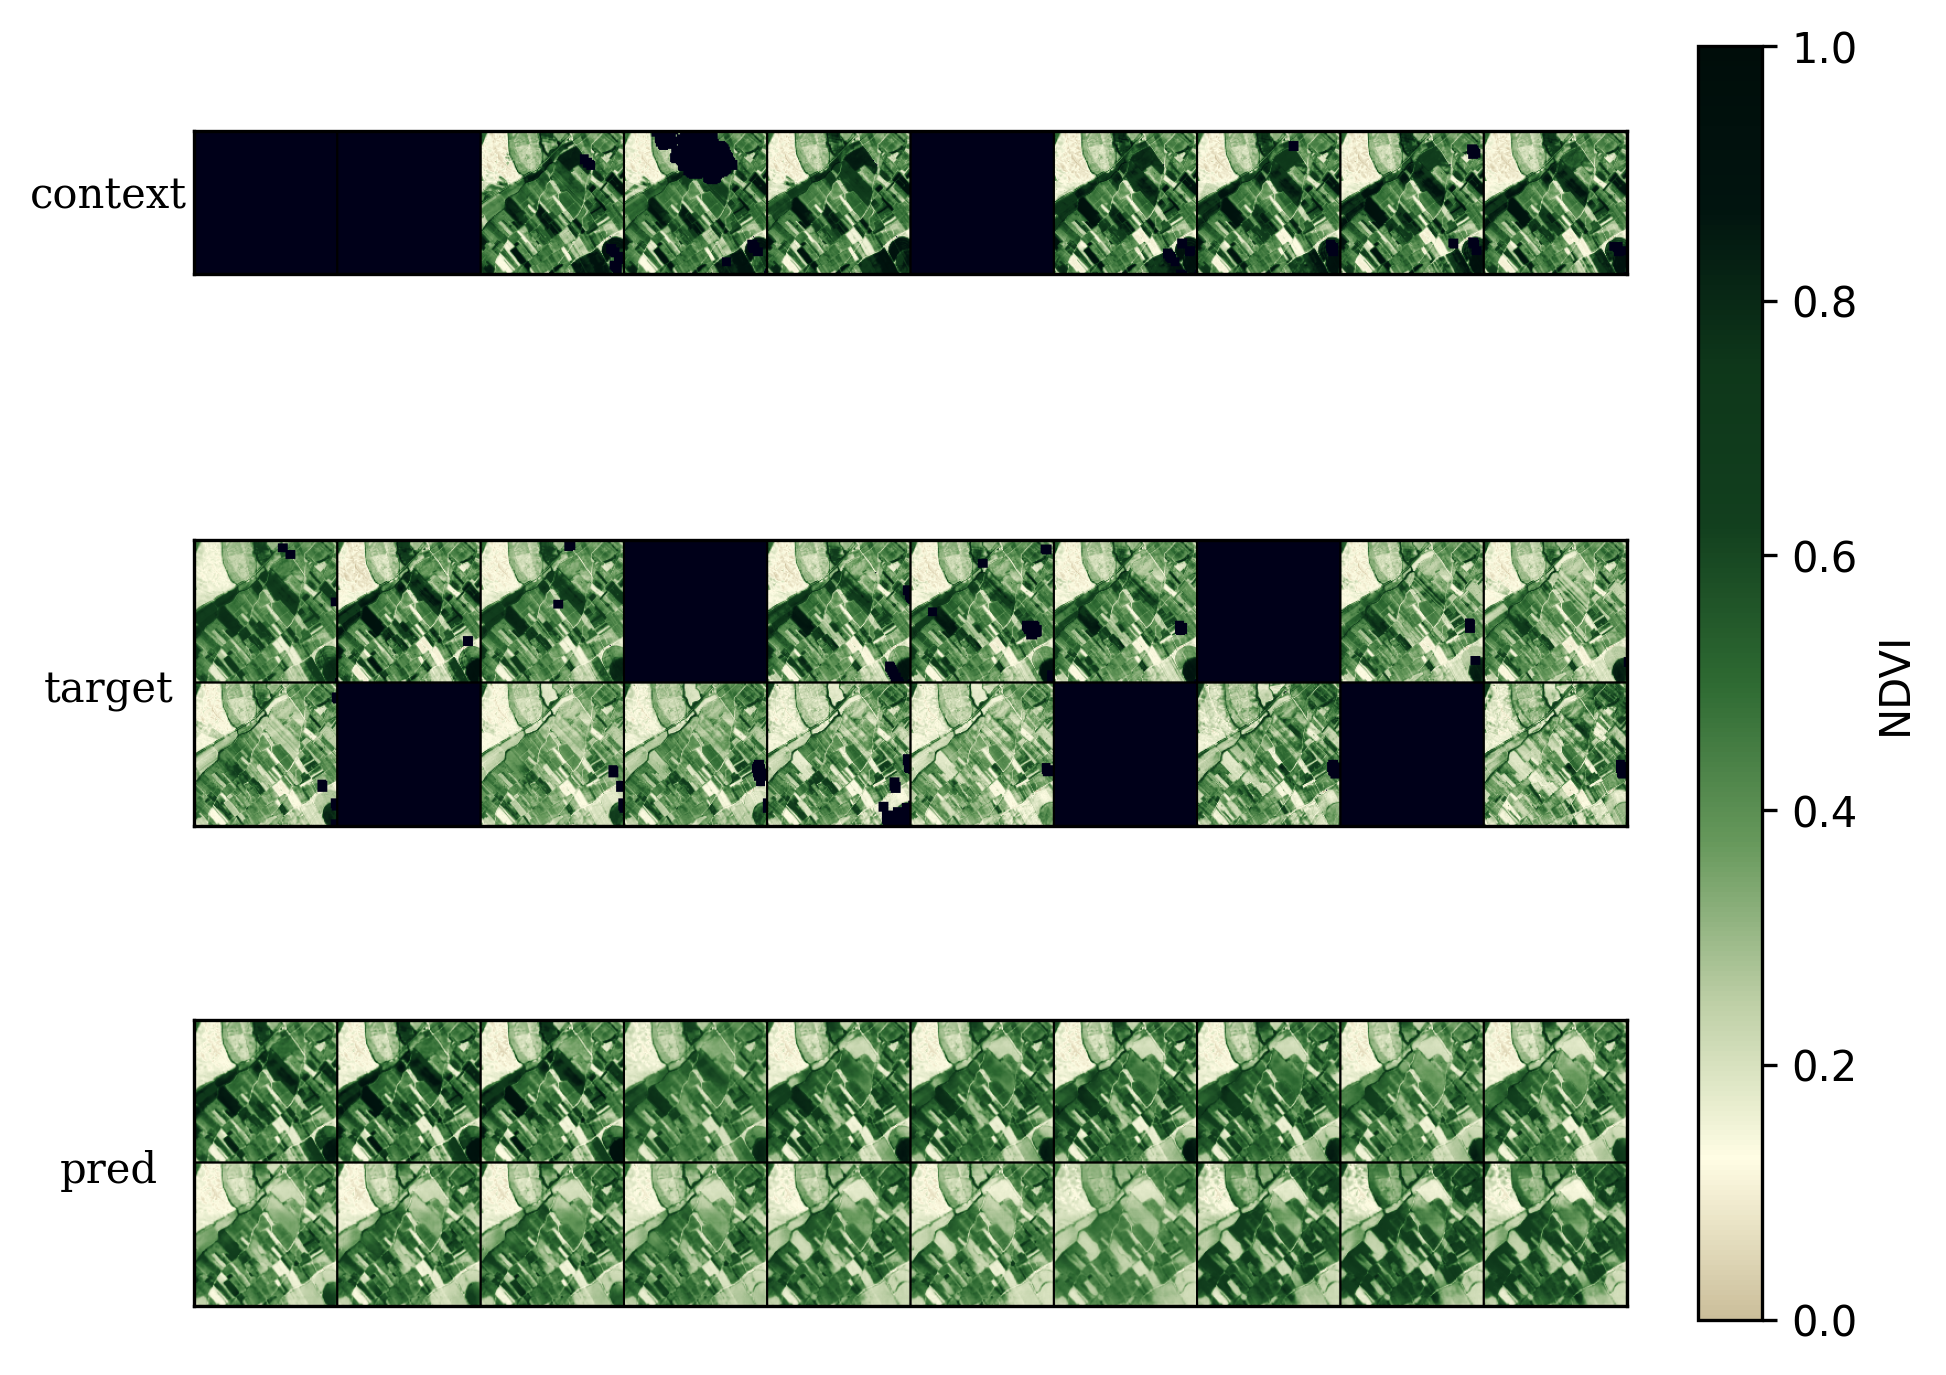

In [7]:
fig_ndvi = vis_earthnet_seq(context_np=np.expand_dims(highresdynamic_in, axis=0),
                           target_np=np.expand_dims(highresdynamic_out, axis=0),
                           pred_np=pred_seq_np,
                           layout='N' + config.dataset.layout,
                           variable="ndvi")

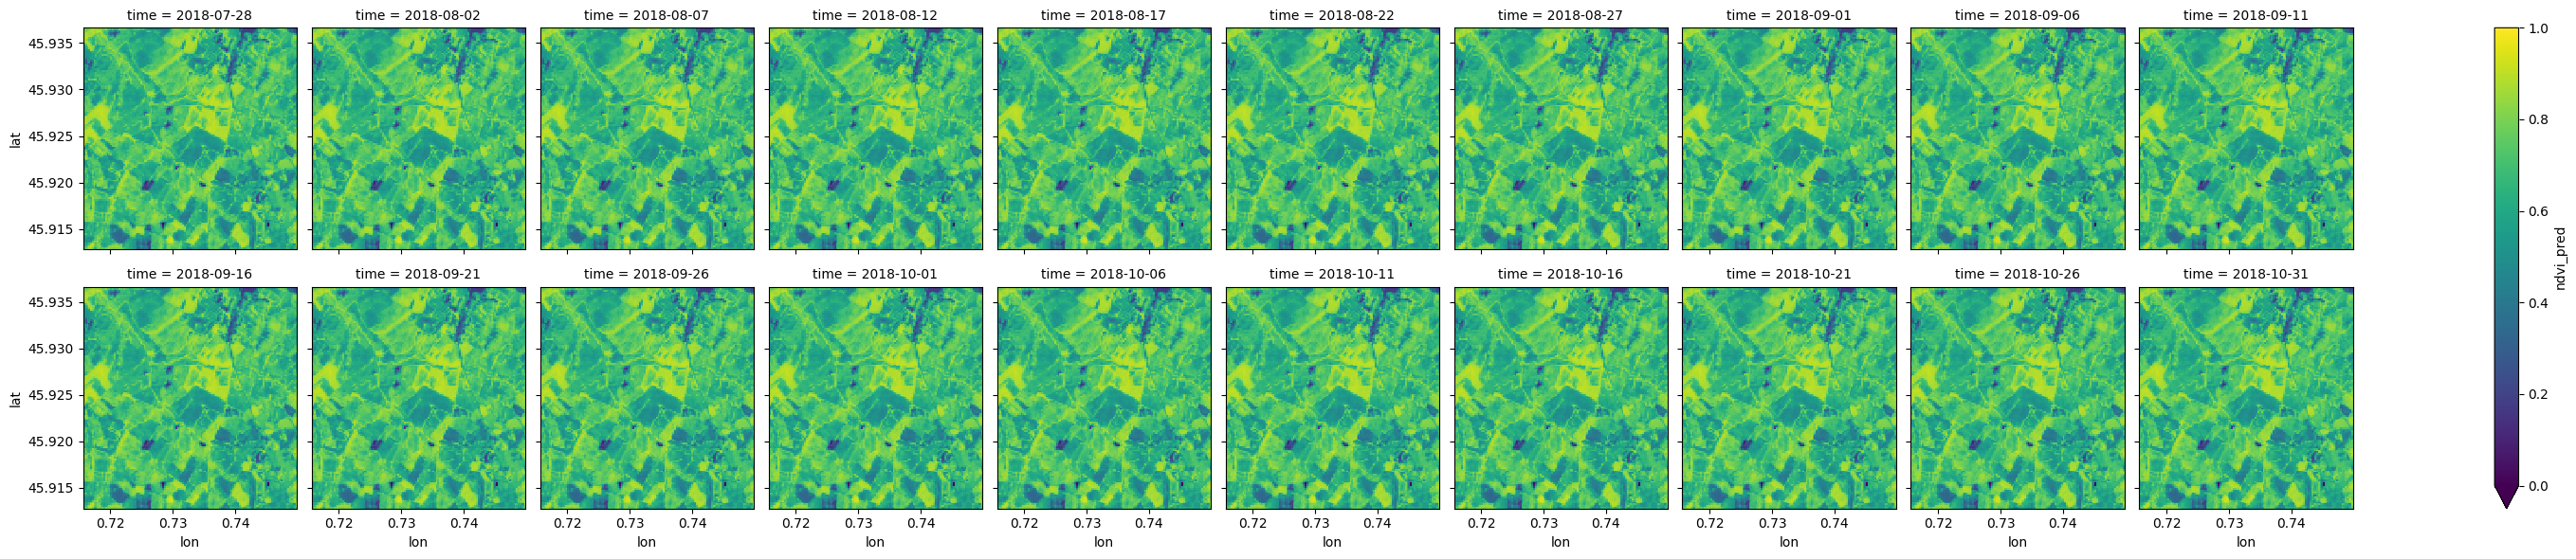

In [13]:
import xarray as xr
mc = xr.open_dataset("/Net/Groups/BGI/people/vbenson/EarthNet/earthnet-models-pytorch/experiments/en21x/persistence/preds/iid/30TYR/30TYR_2018-06-04_2018-10-31_313_441_4409_4537_4_84_68_148.nc")
mc.ndvi_pred.plot.imshow(col = "time", col_wrap = 10, vmin = 0.0, vmax = 1.0)

You can see that the predictions are close to the ground-truth. In addition, the original dataset contain observational noises and some of the target frames are blank. However, Earthformer is able to give reasonable predictions.

## More Details

For more details, check our code-base https://github.com/amazon-science/earth-forecasting-transformer and the [Earthformer paper](https://assets.amazon.science/89/ad/cb9c23dd4bb69b8e03bbbecdb4b8/earthformer-exploring-space-time-transformers-for-earth-system-forecasting.pdf).
